## Show results - Test 

In [1]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard

from src.util.plots import *

fig_dir = '../figures/'

2020-10-23 09:10:16,959 - climada - DEBUG - Loading default config file: C:\Users\valen\Documents\GitHub\climada_python-1.4.2\climada\conf\defaults.conf


## Damage cost for each scenario, year and labor type

In [2]:
pickle_in = \
open('../../output/mortality_results/impact_5mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

agg_impacts_mc = impacts_mortality.agg_impacts_mc
median_impact_matrices = impacts_mortality.median_impact_matrices


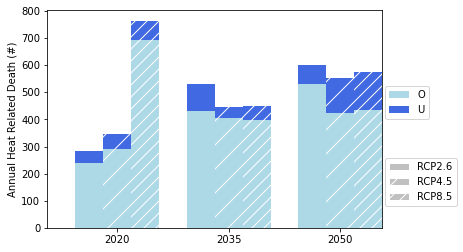

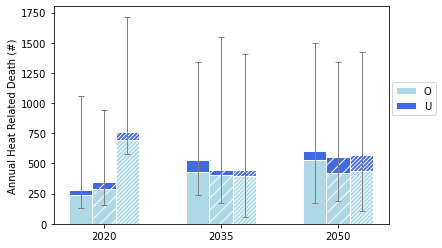

In [3]:
plot_impacts_heat(agg_impacts_mc, 'Annual Heat Related Death (#)', color=['lightblue', 'royalblue'])

#plt.savefig(''.join([fig_dir,'loss_ch/predicted_loss_2020_2065_werror.pdf']),bbox_inches='tight')


## Spatial Impact

2020-10-23 09:11:09,043 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5


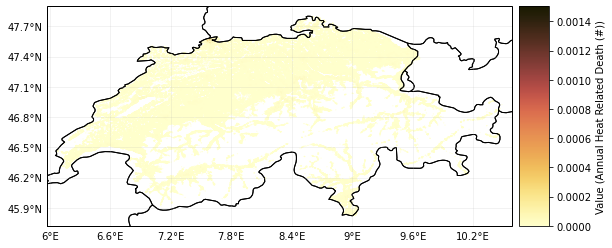

In [5]:
category = 'O'
cm = palettable.scientific.sequential.LaJolla_20.mpl_colormap

directory_exposures = '../../input_data/exposures/'
exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', category, '.h5'])
exposures = Exposures()
exposures.read_hdf5(exposures_file)
impact = impact_matrix_as_impact(median_impact_matrices['RCP85'][2020]['U'], exposures, units='Annual Heat Related Death (#)', percentage=False)
impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

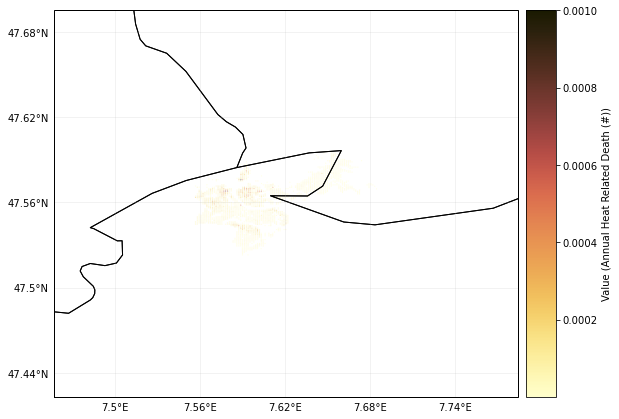

In [9]:
impact = impact_matrix_as_impact(median_impact_matrices['RCP85'][2020]['U'], exposures, units='Annual Heat Related Death (#)', percentage=False, canton='Basel-Stadt')
impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)